In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
import phantom_builder
from core import *
import open3d as o3d
from open3d import io, visualization

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import functools

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Make Phantom

In [2]:

voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = io.read_triangle_mesh("../assets/breast_files/breast_surface.ply")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh) 

In [3]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=1)
fat = tissue.Tissue(name='fat', c=1440.2, rho=911, sigma=30, scale=0.0005, label=2)
ligament = tissue.Tissue(name='ligament', c=1750, rho=1142, sigma=30, scale=0.0001, label=3)
gland = tissue.Tissue(name='gland', c=1564, rho=1041, sigma=40, scale=0.0002, label=4)
tumor = tissue.Tissue(name='tumor', c=1500, rho=911, sigma=0, scale=0.0001, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=4, scale=0.001, label=6)

kidney_file_dir = "../assets/breast_files/"
kidney_tissue_list = [skin, fat, skin, gland, gland, ligament, muscle, tumor]

test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added skin
Added fat
Added skin
Added gland
Added gland
Added ligament
Added muscle
Added tumor


In [4]:
test_phantom.matrix_dims = np.array(test_phantom.mask.shape)
test = test_phantom.get_complete()

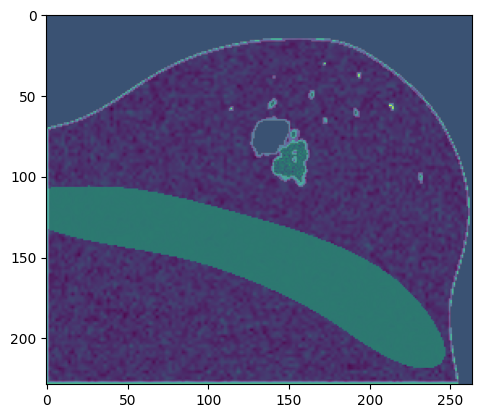

In [5]:
index = 140
plt.imshow(test[0, :, :, index])
bm = np.flip(body_mask, axis=0)
plt.imshow(body_mask[:,:, index] * 1000, alpha=0.2, cmap='Reds_r')

# Set up simulation

In [6]:
num_transducers = 1

transducers = [transducer.Focused(max_frequency = 2.5e6,
                                  elements = 128, 
                                  width = 20e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/2,
                                  ray_num = 64,
                                  imaging_ndims = 2,
                                  focus_azimuth = 20e-3,
                                  focus_elevation = 40e-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [7]:
# pt, normal = test_transducer_set.place_on_mesh_voxel(0, surface_mesh,[150,150,300], voxel_size[0])
# pt = np.array([pt[2], pt[0], pt[1]])
# normal = -np.array([normal[2], normal[0], normal[1]])

# pose = geometry.Transform.make_from_heading_vector(normal, pt)

# theta = -np.pi/2
# # theta = 0
# about_nl_axis = geometry.Transform(rotation=tuple(theta*normal), translation=(0,0,0), about_axis=True)

# transducer_pose = about_nl_axis * pose

# test_transducer_set.assign_pose(0, transducer_pose)


In [14]:
transform1 = geometry.Transform([0,0,0], [0,0,0])
transform2 = geometry.Transform([0,0,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
position = [-0.05,0.01,0]
transform.translation = (transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(0, transform)

In [15]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [16]:
np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test.shape[1:])/2

array([ 14.49999851, 151.99999955, 141.5       ])

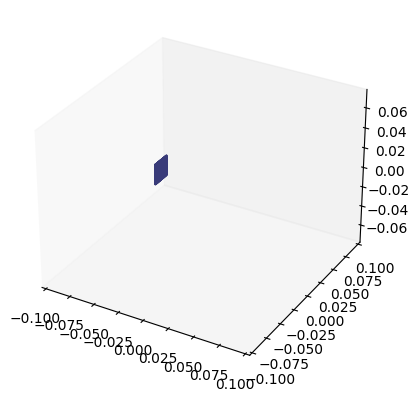

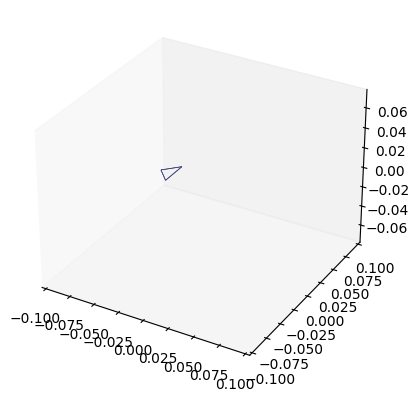

In [17]:
test_transducer_set.plot_transducer_coords()
test_transducer_set.plot_transducer_fovs()

In [27]:
simprops = simulation.SimProperties(
                grid_size   = (60e-3,20e-3,20e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [28]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/breast_experiment_01',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

In [29]:
(np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test.shape[1:]))[2]//2

141.0

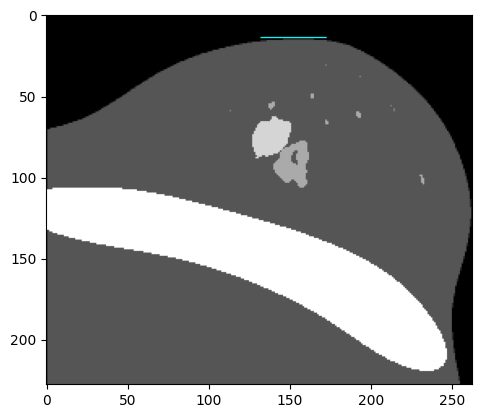

In [30]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int((np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test.shape[1:]))[2]//2)])

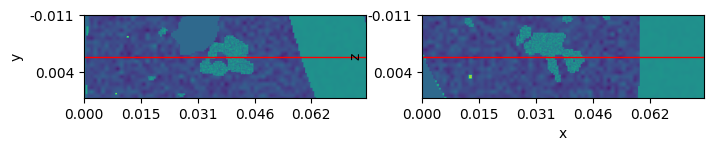

In [31]:
test_experiment.plot_ray_path(31)

# Run Simulation

In [2]:
test_experiment = experiment.Experiment.load('../experiment_files/breast_experiment_01')
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


In [33]:
test_experiment.run(repeat=True)

running with 3 workers



KeyboardInterrupt: 

preparation for sim    0 completed in 68.82 seconds
preparation for sim   32 completed in 69.53 seconds
preparation for sim   33 completed in 86.31 seconds
preparation for sim    1 completed in 87.45 seconds
preparation for sim   34 completed in 73.20 seconds
preparation for sim    2 completed in 76.00 seconds
simulation             0 completed in 244.11 seconds
simulation            32 completed in 189.66 seconds
preparation for sim    3 completed in 77.04 seconds
preparation for sim   35 completed in 82.29 seconds
simulation             1 completed in 225.57 seconds
simulation            33 completed in 190.76 seconds
preparation for sim   36 completed in 76.17 seconds
preparation for sim    4 completed in 78.90 seconds
simulation             2 completed in 218.90 seconds
simulation            34 completed in 188.74 seconds
preparation for sim   37 completed in 75.07 seconds
preparation for sim    5 completed in 75.68 seconds
simulation             3 completed in 219.42 seconds
simul

# Reconstruction

In [3]:
test_experiment.add_results()

In [4]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [5]:
signals = test_reconstruction.get_signals(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)

100%|██████████| 64/64 [00:20<00:00,  3.10it/s]
1it [00:01,  1.27s/it]


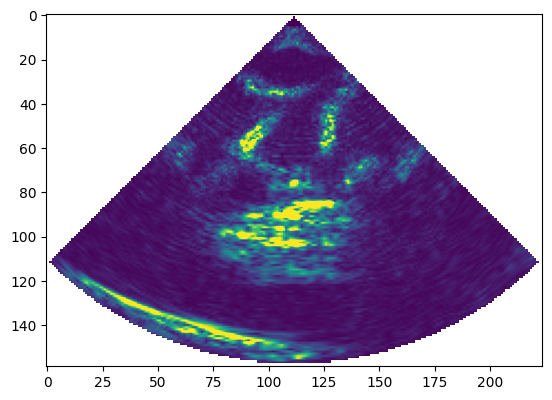

In [6]:
plt.imshow(signals[0], vmax=160000)
